# Use cifar on the autoencoder

In [40]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import requests
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EResNet,ResBlock,EncResBlock
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.applications.imagenet_utils import decode_predictions,preprocess_input
from keras.preprocessing import image
# from tabulate import tabulate

In [27]:
# Cat synset
wnid = 'n02121620'

dog_wnid = 'n02094433'
kit_fox = 'n02119789'

In [134]:
def get_mapping(wnid):
    endpoint = 'http://www.image-net.org/api/text/imagenet.synset.geturls.getmapping?wnid={}'.format(wnid)
    resp = requests.get(endpoint)
    mapping = resp.text.split('\r\n')
    slugs = []
    urls = []
    for m in mapping:
        s = m.split(' ')
        if len(s) > 1:
            slugs.append(s[0])
            urls.append(s[1])
        
    return (slugs,urls)
    
class SynSet(object):
    def __init__(self,wnid,data_dir='/home/elijahc/data/imagenet'):
        self.data_dir = data_dir
        self.wnid = wnid
        slugs,urls = get_mapping(self.wnid)
        self.slugs = slugs
        self.urls = urls
        self._url2id = None
        self._id2url = None
        self.bbox_dir = None
    
    def geturls(self):
        endpoint = 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid={}'.format(self.wnid)
        resp = requests.get(endpoint)
        urls = resp.text.split('\r\n')
        return urls
    
    def url2id(self,url):
        if self._url2id is None:
            self._url2id = {k:v for k,v in zip(self.urls,self.slugs)}
        return self._url2id[str(url)]
    
    def id2url(self,image_id):
        if self._id2url is None:
            self._id2url = {k:v for k,v in zip(self.slugs,self.urls)}
        return self._id2url[str(image_id)]
    
    def get_bbox(self,image_id,bbox_dir=None):
        if bbox_dir is None:
            self.bbox_dir = os.path.join(self.data_dir,'Annotation',str(self.wnid))
        
        bbox_fp = os.path.join(self.bbox_dir,str(self.wnid)+'_{}.xml'.format(image_id))
        root = ET.parse(bbox_fp).getroot()
        bboxes = []
        for o in root.findall('./object'):
            bbox = {}
            for c in o[-1]:
                bbox[c.tag]=int(c.text)
            bboxes.append(bbox)
        return bboxes
            
        
kit_fox = SynSet(wnid='n02119789',data_dir='/home/elijahc/data/imagenet/examples/kit_fox')

urls = kit_fox.geturls()
print(len(urls))
urls[:5]

828


['http://farm1.static.flickr.com/9/14720420_8830007ef2.jpg',
 'http://filin.vn.ua/image/enot/v.chama.jpg',
 'http://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Kitfuchs.jpg/260px-Kitfuchs.jpg',
 'http://www.nps.gov/pwr/customcf/apps/CMS_HandF/GreenBoxPics/GRBA_marmot375x100.jpg',
 'http://img.search.com/thumb/7/73/Coyote_portrait.jpg/200px-Coyote_portrait.jpg']

In [135]:
kit_fox.slugs[:10]

['n02119789_8097',
 'n02119789_8122',
 'n02119789_8126',
 'n02119789_2168',
 'n02119789_8139',
 'n02119789_8141',
 'n02119789_8146',
 'n02119789_8174',
 'n02119789_8197',
 'n02119789_8231']

In [136]:
kit_fox.id2url('n02119789_8146')

'http://static2.postcrossing.com/postcard/medium/9dbf1daeb15171e70dfe1fb8885b8be4.jpg'

In [137]:
bbox = kit_fox.get_bbox(image_id=8146)[0]

In [138]:
bbox

{'xmax': 424, 'xmin': 124, 'ymax': 262, 'ymin': 63}

In [ ]:
im_path = '/home/elijahc/data/imagenet/examples/n02094433/yorkshireterrier_lucas103062.jpg'
image_pil = image.load_img(im_path,
                           target_size=(56,56),
                          )
im_np = image.img_to_array(image_pil, data_format='channels_last')
plt.imshow(np.uint8(im_np))

In [2]:
config,_ = get_config()

# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',True)
# setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-01-17/')

# Architecture Params
setattr(config, 'enc_blocks', [32,64,128,256])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 10)
setattr(config, 'y_dim', 10)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 100)
setattr(config, 'monitor', 'val_G_loss')
setattr(config, 'min_delta', 0.25)
setattr(config, 'optimizer', 'adam')

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 25)
setattr(config, 'xent', 15)

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)

{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': True,
 'enc_blocks': [32, 64, 128, 256],
 'enc_layers': [500, 500],
 'epochs': 100,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'min_delta': 0.25,
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'proj_root': '/home/elijahc/projects/vae',
 'recon': 25,
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 10}

In [4]:
translation_amt = 0.8 # Med
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=False,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 56, 56, 1)
making training data...
making testing data...


In [5]:
DL.input_shape

(56, 56, 1)

In [6]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks,flatten_out=False)
E_builder = EResNet(blocks=config.enc_blocks,z_dim=config.z_dim,y_dim=config.y_dim)
trainer = Trainer(config,DL,E_builder,G_builder,)
# setattr(trainer.config,'model_dir','/home/elijahc/projects/vae/models/2019-01-22/')

building encoder...
building decoder/generator...


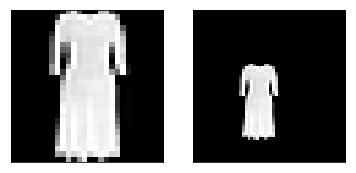

In [7]:
pt,idx = plot_ovt(DL,cmap='gray')

In [8]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [9]:
trainer.compile_model()
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
block_1_BN_0 (BatchNormalizatio (None, 56, 56, 1)    4           input_image[0][0]                
__________________________________________________________________________________________________
block_1_ReLU_0 (Activation)     (None, 56, 56, 1)    0           block_1_BN_0[0][0]               
__________________________________________________________________________________________________
block_1_conv_0 (Conv2D)         (None, 56, 56, 32)   320         block_1_ReLU_0[0][0]             
__________________________________________________________________________________________________
block_1_BN

In [ ]:
trainer.go(x=DL.sx_train,
           y={
               'class':DL.y_train_oh,
#                'D_real':RF,
               'G':DL.sx_train},
           validation_split=0.05,
           verbose=0)

Epoch        G_loss      val_G_loss  val_class_acc
0:           133.6282    77.1956     0.414       
1:           54.1963     87.4372     0.4793      
2:           45.9284     88.238      0.639       
3:           40.1682     87.3202     0.6887      
4:           36.4211     68.348      0.6917      
5:           33.9353     47.8332     0.743       
6:           32.1365     39.038      0.7333      
7:           30.9323     35.7339     0.739       
8:           30.0824     31.411      0.7537      
9:           29.1999     32.9352     0.7403      
10:          28.3102     30.3528     0.7483      
11:          27.6957     29.0904     0.7413      
12:          27.1628     27.8128     0.7493      
13:          26.2954     27.4884     0.7373      
14:          25.578      26.3936     0.7177      
15:          25.1229     25.3104     0.7473      


In [ ]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

In [ ]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [ ]:
# if not config.dev_mode:
# trainer.save_model()

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
generator = trainer.G

In [ ]:
trainer.E.summary()

In [ ]:
z_encoder = Model(trainer.input,trainer.z_lat)
classifier = Model(trainer.input,trainer.y_class)
# y_lat_encoder = Model(trainer.E.input,trainer.y_lat)
# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-(1+(5*2)):]
# print(dec_layers)
# _gen_x = dec_layers[0](decoder_inp)
# l = dec_layers[1]
# isinstance(l,keras.layers.core.Reshape)
# F = None
# for l in dec_layers[1:]:
#     print(type(l))
    
#     if isinstance(l,keras.layers.merge.Add):
#         _gen_x = l([F,_gen_x])
#     else:
#         _gen_x = l(_gen_x)
    
#     if isinstance(l,keras.layers.convolutional.Conv2DTranspose):
#         if l.kernel_size==(1,1):
#             F = _gen_x
            
# # generator = Model(decoder_inp,_gen_x)

In [ ]:
classifier.summary()

In [ ]:
DL.y_test_oh.shape

In [ ]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

In [ ]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [ ]:
_lat_vec = np.concatenate([y_lat,z_enc],axis=1)
_lat_vec.shape

In [ ]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [ ]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

In [ ]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

In [ ]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
_lat_vec[rand_im]

In [ ]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=False,
                         rotation=None,
                         translation=translation_amt,
                        )

In [ ]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_lat,generator)

In [ ]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [ ]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

In [ ]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_lat[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [ ]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,50)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(config.z_dim+config.y_dim)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [ ]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [ ]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(25)]

In [ ]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(25)]

In [ ]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(25)]

In [ ]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [ ]:
config.translation_amt = translation_amt
config.translation_amt

In [ ]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [ ]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylim(0,0.9)
ax.set_xlim(0,0.9)
points = plt.scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='plasma')
plt.colorbar(points)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.